In [2]:
import os
import sys
import glob

sys.path.append(os.getcwd())

import torch
from lossless.component.coolchic import CoolChicEncoderParameter
from lossless.component.frame import load_frame_encoder
from lossless.component.types import NAME_COOLCHIC_ENC
from lossless.component.image import (
    FrameEncoderManager,
    encode_one_frame,
)
from enc.utils.codingstructure import CodingStructure, Frame
from typing import Any, Dict, List
from lossless.component.coolchic import CoolChicEncoder
from torchac import torchac
import numpy as np
import cv2
import matplotlib.pyplot as plt

from lossless.util.config import (
    DATASET_PATH,
    TEST_WORKDIR,
    PATH_COOL_CHIC_CFG,
    IMAGE_PATHS,
    args,
    start_print
)
from lossless.util.print_formatting import pretty_str_dict
from lossless.util.parsecli import change_n_out_synth, get_coolchic_param_from_args, get_manager_from_args
from lossless.util.misc import clean_workdir
from lossless.training.train import train
from lossless.util.encoding import encode, decode
from lossless.util.distribution import get_scale
from lossless.nnquant.quantizemodel import quantize_model
from lossless.training.loss import loss_function

# print(IMAGE_PATHS)
# print(pretty_str_dict(args))
# print("----------")
# print(start_print)

frame_encoder_manager = FrameEncoderManager(**get_manager_from_args(args))

In [ ]:
# clean_workdir(args["workdir"])

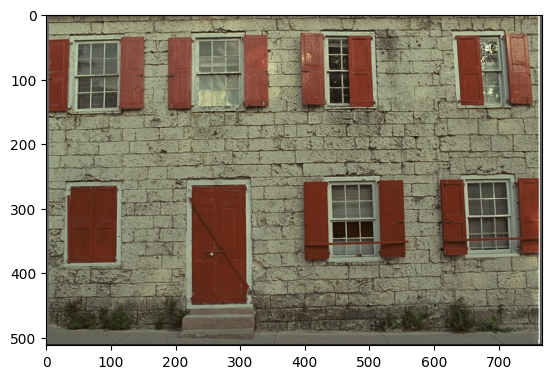

In [3]:
im = cv2.imread(filename=args["input"])
assert im is not None, f"Failed to read image {args['input']}"
im = im[:, :, ::-1]  # Convert BGR to RGB
plt.imshow(im)
plt.show()

im_tensor = torch.from_numpy(im.copy()).float() / 255.0  # Normalize to [0, 1]
im_tensor = im_tensor.permute((2, 0, 1))[None,]  # Change to CxHxW
im_tensor = im_tensor.to("cuda" if torch.cuda.is_available() else "cpu")


encoder_param = CoolChicEncoderParameter(
    **get_coolchic_param_from_args(args, "residue")
)
encoder_param.set_image_size((512, 768))
encoder_param.layers_synthesis = change_n_out_synth(
    encoder_param.layers_synthesis, 6
)

coolchic = CoolChicEncoder(param=encoder_param)
coolchic.to_device("cuda:0")

In [ ]:
# LOAD OR TRAIN THE MODEL
if args["use_pretrained"]:
    coolchic.load_state_dict(torch.load(args["pretrained_model_path"]))
else:
    coolchic = train(
        model=coolchic,
        target_image=im_tensor,
        frame_encoder_manager=frame_encoder_manager,
        start_lr=args["start_lr"],
        lmbda=args["lmbda"],
        cosine_scheduling_lr=args["schedule_lr"],
        max_iterations=args["n_itr"],
        frequency_validation=args["freq_valid"],
        patience=args["patience"],
        optimized_module=args["optimized_module"],
        quantizer_type=args["quantizer_type"],
        quantizer_noise_type=args["quantizer_noise_type"],
        softround_temperature=args["softround_temperature"],
        noise_parameter=args["noise_parameter"],
        loss_latent_multiplier=1.0,
    )

# with torch.no_grad():
#     # Forward pass with no quantization noise
#     # This is a random prior, i.e. the output is not conditioned on any input
#     # image.
#     coolchic.eval()
#     predicted_priors = coolchic.forward(
#         quantizer_noise_type="none",
#         quantizer_type="hardround",
#         AC_MAX_VAL=-1,
#         flag_additional_outputs=False,
#     )
#     predicted_priors_rates = loss_function(predicted_priors, im_tensor, latent_multiplier=1.0)
# print(f"Predicted prior: {predicted_priors.keys()}")

In [5]:
# print(predicted_priors["raw_out"].size())
# print(predicted_priors["rate"].size())
# # print(random_prior["additional_data"])
# print(torch.min(predicted_priors["raw_out"]), torch.max(predicted_priors["raw_out"]))

# for slice_index in range(6):
#     image_tensor_2d = predicted_priors["raw_out"].cpu().numpy()[0, slice_index]
#     plt.imshow(
#         image_tensor_2d,
#         cmap="gray",
#     )
#     plt.colorbar()
#     plt.show()

In [6]:
# mu = predicted_priors["raw_out"][:, :3]
# scale = predicted_priors["raw_out"][:, 3:6]
# im_tensor_plottable = im_tensor[0].permute(1, 2, 0).cpu().numpy()
# mu_plottable = mu[0].permute(1, 2, 0).cpu().numpy()
# scale_plottable = scale[0].permute(1, 2, 0).cpu().numpy()

# channel = 2
# diff = im_tensor_plottable[:,:,channel]*2-1 - mu_plottable[:,:,channel]
# diff = np.abs(diff)
# print(np.mean(diff), np.min(diff), np.max(diff))
# plt.imshow(diff, cmap='gray')
# plt.title("Input image - mu")
# plt.colorbar()
# plt.show()
# plt.imshow(mu_plottable[:,:,channel], cmap='gray')
# plt.title("Mu - channel {}".format(channel))
# plt.colorbar()
# plt.show()
# plt.imshow(scale_plottable[:,:,channel], cmap='gray')
# plt.title("Scale - channel {}".format(channel))
# plt.colorbar()
# plt.show()

In [ ]:
def get_bits_per_pixel(w, h, c, encoded_bytes):
    num_pixels = w * h * c
    num_bits = 0
    for bytes_channel in encoded_bytes:
        num_bits += len(bytes_channel) * 8
    return num_bits / num_pixels

# mu = predicted_priors["raw_out"][:, :3]
# scale = predicted_priors["raw_out"][:, 3:6]
# scale_proper = get_scale(scale)
# clamp_scale_to = 0.2
# # print(f"mu: {mu.min()} {mu.max()}, scale: {scale_proper.min()} {scale_proper.max()}")
# encoded_bytes = encode(im_tensor,  mu, scale_proper)
# assert predicted_priors_rates.rate_latent_bpd is not None
# print(get_bits_per_pixel(768, 512, 3, encoded_bytes) + predicted_priors_rates.rate_latent_bpd)

In [19]:
# # CHECK WITH DECODED IMAGE
# decoded_im = decode(encoded_bytes, mu, get_scale(scale))
# decoded_im = decoded_im.cpu().numpy()
# print(np.min(decoded_im), np.max(decoded_im))

# plt.imshow(np.transpose(decoded_im[0], (1, 2, 0)))
# plt.show()
# assert np.allclose(decoded_im, im_tensor.cpu().numpy()), "Decoded image does not match original"
# print(f"PNG bpd: {736501 / 768 / 512 / 3 * 8:.3f} vs New lossless method: {get_bits_per_pixel(768, 512, 3, encoded_bytes):.3f}")

In [15]:
# # Let's verify the fix worked by checking reconstruction
# print("🔍 VERIFYING LOSSLESS RECONSTRUCTION:")
# print("-" * 40)

# print(f"Original image shape: {im_tensor.shape}")
# print(f"Original image range: [{im_tensor.min():.6f}, {im_tensor.max():.6f}]")

# print(f"\nDecoded image shape: {decoded_im.shape}")
# print(f"Decoded image range: [{decoded_im.min():.6f}, {decoded_im.max():.6f}]")

# # Check if reconstruction is perfect (lossless)
# reconstruction_error = np.abs(im_tensor.cpu().numpy() - decoded_im).max()
# print(f"\nMax reconstruction error: {reconstruction_error:.10f}")

# if reconstruction_error < 1e-6:
#     print("✅ SUCCESS: Perfect lossless reconstruction!")
# else:
#     print(f"❌ ISSUE: Reconstruction error = {reconstruction_error}")
    
#     # Let's check per channel
#     for i in range(3):
#         channel_error = np.abs(im_tensor[0, i].cpu().numpy() - decoded_im[0, i]).max()
#         print(f"   Channel {i} error: {channel_error:.10f}")

# # Check some statistics
# print(f"\nChannel statistics:")
# for i in range(3):
#     orig_mean = im_tensor[0, i].mean().item()
#     decoded_mean = decoded_im[0, i].mean()
#     print(f"   Channel {i}: Original mean={orig_mean:.6f}, Decoded mean={decoded_mean:.6f}")

In [14]:
quantized_coolchic = CoolChicEncoder(param=encoder_param)
quantized_coolchic.to_device("cuda:0")
quantized_coolchic.set_param(coolchic.get_param())
quantized_coolchic = quantize_model(
    quantized_coolchic, im_tensor, frame_encoder_manager
)
rate_per_module, total_rate = quantized_coolchic.get_network_rate()
# print(rate_per_module)
total_rate /= im_tensor.numel()

Best loss for module arm: Loss: 3.6755, Rate NN: 0.0013, Rate Latent: 1.3473, Rate Img: 2.3269
Best loss for module synthesis: Loss: 3.6857, Rate NN: 0.0108, Rate Latent: 1.3473, Rate Img: 2.3275
Best loss for module upsampling: Loss: 3.6862, Rate NN: 0.0114, Rate Latent: 1.3473, Rate Img: 2.3276

Time quantize_model(): 11.9 seconds



In [17]:
with torch.no_grad():
    # Forward pass with no quantization noise
    # This is a random prior, i.e. the output is not conditioned on any input
    # image.
    random_prior_check = quantized_coolchic.forward(
        quantizer_noise_type="none",
        quantizer_type="hardround",
        AC_MAX_VAL=-1,
        flag_additional_outputs=False,
    )
    predicted_priors_rates_check = loss_function(random_prior_check, im_tensor, latent_multiplier=1.0)
    print(predicted_priors_rates_check)
print(f"Random prior: {random_prior_check.keys()}")

mu_check = random_prior_check["raw_out"][:, :3]
scale_check = random_prior_check["raw_out"][:, 3:6]
scale_proper_check = get_scale(scale_check)
clamp_scale_to = 0.2
print(f"mu: {mu_check.min()} {mu_check.max()}, scale: {scale_proper_check.min()} {scale_proper_check.max()}")
encoded_bytes_check = encode(im_tensor,  mu_check, scale_proper_check)
assert predicted_priors_rates_check.rate_latent_bpd is not None
print(get_bits_per_pixel(768, 512, 3, encoded_bytes_check) + predicted_priors_rates_check.rate_latent_bpd + float(total_rate))

Loss: 3.6749, Rate NN: 0.0000, Rate Latent: 1.3473, Rate Img: 2.3276
Random prior: dict_keys(['raw_out', 'rate', 'latent_bpd', 'additional_data'])
mu: -1.3732186555862427 2.071550130844116, scale: 0.0018079705769196153 0.05739549174904823
3.6811005278593965


In [18]:
# im_tensor_plottable = im_tensor[0].permute(1, 2, 0).cpu().numpy()
# mu_plottable = mu_check[0].permute(1, 2, 0).cpu().numpy()
# scale_plottable = scale_proper_check[0].permute(1, 2, 0).cpu().numpy()

# channel = 2
# diff = im_tensor_plottable[:,:,channel]*2-1 - mu_plottable[:,:,channel]
# diff = np.abs(diff)
# print(np.mean(diff), np.min(diff), np.max(diff))
# plt.imshow(diff, cmap='gray')
# plt.title("Input image - mu")
# plt.colorbar()
# plt.show()
# plt.imshow(mu_plottable[:,:,channel], cmap='gray')
# plt.title("Mu - channel {}".format(channel))
# plt.colorbar()
# plt.show()
# plt.imshow(scale_plottable[:,:,channel], cmap='gray')
# plt.title("Scale - channel {}".format(channel))
# plt.colorbar()
# plt.show()

In [12]:
# save coolchic to file 0000_trained_model.
torch.save(quantized_coolchic.state_dict(), f"{TEST_WORKDIR}/0000_trained_coolchic_img_rate_{get_bits_per_pixel(768, 512, 3, encoded_bytes_check)}.pth")